In [3]:
import pandas as pd
from pybaseball import statcast
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [3]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 589/589 [01:54<00:00,  5.15it/s]
/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 229/229 [00:47<00:00,  4.80it/s]
/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [45]:
#Read in data
data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
data23 = pd.read_csv("Statcast_2023.csv")

In [46]:
#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year','delta_run_exp']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year','delta_run_exp']]

In [47]:
#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

In [48]:
#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

In [49]:
#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

In [50]:
#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')



In [51]:
#Seperate pitches for different models
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball'])]

sinker_20_22 = data20_22[data20_22.pitch_type.isin(['Sinker'])]
sinker_23 = data23[data23.pitch_type.isin(['Sinker'])]

cutter_20_22 = data20_22[data20_22.pitch_type.isin(['Cutter'])]
cutter_23 = data23[data23.pitch_type.isin(['Cutter'])]

slider_20_22 = data20_22[data20_22.pitch_type.isin(['Slider'])]
slider_23 = data23[data23.pitch_type.isin(['Slider'])]

sweeper_20_22 = data20_22[data20_22.pitch_type.isin(['Sweeper'])]
sweeper_23 = data23[data23.pitch_type.isin(['Sweeper'])]

curveball_20_22 = data20_22[data20_22.pitch_type.isin(['Curveball'])]
curveball_23 = data23[data23.pitch_type.isin(['Curveball'])]

changeup_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup'])]
changeup_23 = data23[data23.pitch_type.isin(['Changeup'])]

splitter_20_22 = data20_22[data20_22.pitch_type.isin(['Splitter'])]
splitter_23 = data23[data23.pitch_type.isin(['Splitter'])]


In [52]:
#Split into train and test
fastball_x = fastball_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
fastball_y = fastball_20_22['delta_run_exp']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

sinker_x = sinker_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
sinker_y = sinker_20_22['delta_run_exp']

x_train_sinker, x_test_sinker, y_train_sinker, y_test_sinker = train_test_split(sinker_x, sinker_y, train_size=0.75, random_state=12345)

cutter_x = cutter_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
cutter_y = cutter_20_22['delta_run_exp']

x_train_cutter, x_test_cutter, y_train_cutter, y_test_cutter = train_test_split(cutter_x, cutter_y, train_size=0.75, random_state=12345)

slider_x = slider_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
slider_y = slider_20_22['delta_run_exp']

x_train_slider, x_test_slider, y_train_slider, y_test_slider = train_test_split(slider_x, slider_y, train_size=0.75, random_state=12345)

sweeper_x = sweeper_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
sweeper_y = sweeper_20_22['delta_run_exp']

x_train_sweeper, x_test_sweeper, y_train_sweeper, y_test_sweeper = train_test_split(sweeper_x, sweeper_y, train_size=0.75, random_state=12345)

curveball_x = curveball_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
curveball_y = curveball_20_22['delta_run_exp']

x_train_curveball, x_test_curveball, y_train_curveball, y_test_curveball = train_test_split(curveball_x, curveball_y, train_size=0.75, random_state=12345)

changeup_x = changeup_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
changeup_y = changeup_20_22['delta_run_exp']

x_train_changeup, x_test_changeup, y_train_changeup, y_test_changeup = train_test_split(changeup_x, changeup_y, train_size=0.75, random_state=12345)

splitter_x = splitter_20_22[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']]
splitter_y = splitter_20_22['delta_run_exp']

x_train_splitter, x_test_splitter, y_train_splitter, y_test_splitter = train_test_split(splitter_x, splitter_y, train_size=0.75, random_state=12345)

In [53]:
#Set params for catboost models
params = {
    'iterations': 100,
    'depth': 5,
    'learning_rate': 0.01,
    'random_seed': 12345
}

In [54]:
#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
sinker_model = CatBoostRegressor(**params)
sinker_model.fit(x_train_sinker, y_train_sinker)

#Cutter
cutter_model = CatBoostRegressor(**params)
cutter_model.fit(x_train_cutter, y_train_cutter)

#Slider
slider_model = CatBoostRegressor(**params)
slider_model.fit(x_train_slider, y_train_slider)

#Sweeper
sweeper_model = CatBoostRegressor(**params)
sweeper_model.fit(x_train_sweeper, y_train_sweeper)

#Curveball
curveball_model = CatBoostRegressor(**params)
curveball_model.fit(x_train_curveball, y_train_curveball)

#Changeup
changeup_model = CatBoostRegressor(**params)
changeup_model.fit(x_train_changeup, y_train_changeup)

#Splitter
splitter_model = CatBoostRegressor(**params)
splitter_model.fit(x_train_splitter, y_train_splitter)



0:	learn: 0.2404991	total: 15.6ms	remaining: 1.54s
1:	learn: 0.2404934	total: 28ms	remaining: 1.37s
2:	learn: 0.2404871	total: 40.4ms	remaining: 1.31s
3:	learn: 0.2404809	total: 53.3ms	remaining: 1.28s
4:	learn: 0.2404757	total: 65.2ms	remaining: 1.24s
5:	learn: 0.2404704	total: 79.4ms	remaining: 1.24s
6:	learn: 0.2404651	total: 90.7ms	remaining: 1.21s
7:	learn: 0.2404594	total: 103ms	remaining: 1.19s
8:	learn: 0.2404545	total: 116ms	remaining: 1.18s
9:	learn: 0.2404488	total: 130ms	remaining: 1.17s
10:	learn: 0.2404435	total: 143ms	remaining: 1.15s
11:	learn: 0.2404384	total: 156ms	remaining: 1.15s
12:	learn: 0.2404330	total: 169ms	remaining: 1.13s
13:	learn: 0.2404284	total: 181ms	remaining: 1.11s
14:	learn: 0.2404242	total: 192ms	remaining: 1.09s
15:	learn: 0.2404192	total: 204ms	remaining: 1.07s
16:	learn: 0.2404147	total: 216ms	remaining: 1.05s
17:	learn: 0.2404099	total: 229ms	remaining: 1.04s
18:	learn: 0.2404053	total: 241ms	remaining: 1.03s
19:	learn: 0.2404003	total: 254ms	re

In [55]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

sinker_23['pred'] = sinker_model.predict(sinker_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

cutter_23['pred'] = cutter_model.predict(cutter_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

slider_23['pred'] = slider_model.predict(slider_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

sweeper_23['pred'] = sweeper_model.predict(sweeper_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

curveball_23['pred'] = curveball_model.predict(curveball_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

changeup_23['pred'] = changeup_model.predict(changeup_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

splitter_23['pred'] = splitter_model.predict(splitter_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_50951/3765555759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_50951/3765555759.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sinker_23['pred'] = sinker_model.predic

In [56]:
def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['score'] = df['scaled'] / df['scaled'].mean() * 10

scale_and_score(fastball_23)
scale_and_score(sinker_23)
scale_and_score(cutter_23)
scale_and_score(slider_23)
scale_and_score(sweeper_23)
scale_and_score(curveball_23)
scale_and_score(changeup_23)
scale_and_score(splitter_23)

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_50951/3462497741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = df['pred'] - df['pred'].max()
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_50951/3462497741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaled'] = abs(df['scaled'])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_50951/3462497741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [68]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_score'}, inplace=True)
    #top_10_mean_scores = mean_scores.nlargest(10, 'mean_score')
    mean_scores = mean_scores.sort_values(by='mean_score', ascending=False)
    return mean_scores

In [60]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

In [66]:
print("Top 10 Fastball Mean Scores:")
print(calculate_mean_scores(fastball_23))

print("Top 10 Sinker Mean Scores:")
print(calculate_mean_scores(sinker_23))

print("Top 10 Cutter Mean Scores:")
print(calculate_mean_scores(cutter_23))

print("Top 10 Slider Mean Scores:")
print(calculate_mean_scores(slider_23))

print("Top 10 Sweeper Mean Scores:")
print(calculate_mean_scores(sweeper_23))

print("Top 10 Curveball Mean Scores:")
print(calculate_mean_scores(curveball_23))

print("Top 10 Changeup Mean Scores:")
print(calculate_mean_scores(changeup_23))

print("Top 10 Splitter Mean Scores:")
print(calculate_mean_scores(splitter_23))

Top 10 Fastball Mean Scores:
           player_name  mean_score
0       Abad, Fernando    9.363510
1       Abbott, Andrew    9.646292
2         Abbott, Cory   10.304982
3        Abreu, Albert   10.089325
4         Abreu, Bryan   10.329235
..                 ...         ...
781       Zavala, Seby    8.454672
782       Zerpa, Angel    9.140271
783  Zimmermann, Bruce    9.347700
784  Zuñiga, Guillermo    9.822492
785      deGrom, Jacob   11.123293

[786 rows x 2 columns]
Top 10 Sinker Mean Scores:
           player_name  mean_score
0       Abad, Fernando    9.843722
1        Abreu, Albert   10.352125
2     Acevedo, Domingo    8.982184
3           Adon, Joan    9.642212
4        Alcala, Jorge    9.784001
..                 ...         ...
507    Yarbrough, Ryan    9.777018
508        Young, Alex    9.801488
509       Young, Danny    9.811981
510       Zerpa, Angel    9.943112
511  Zimmermann, Bruce    9.709830

[512 rows x 2 columns]
Top 10 Cutter Mean Scores:
          player_name  mean_s

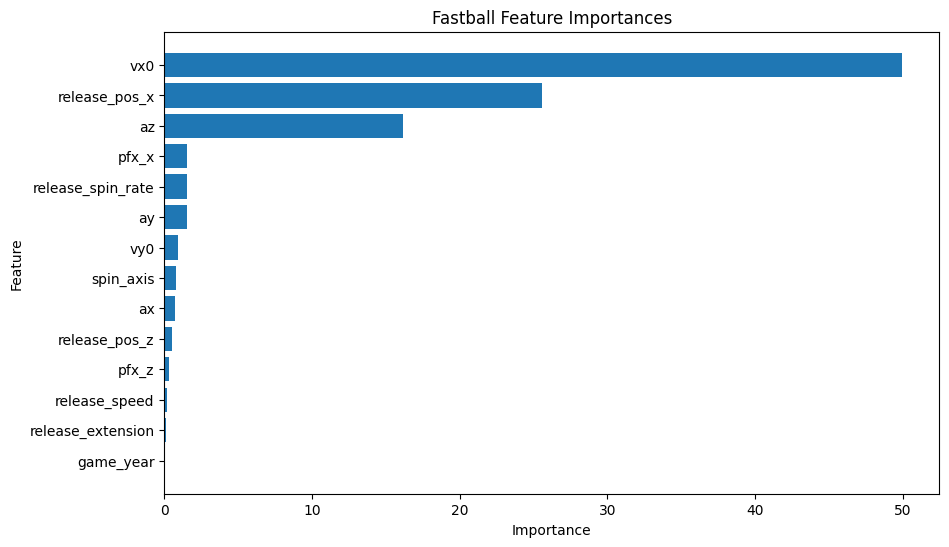

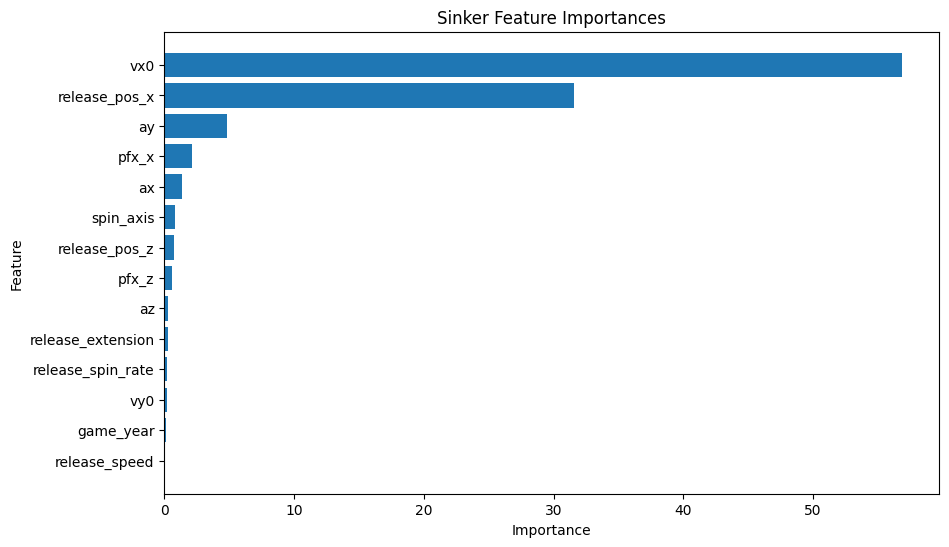

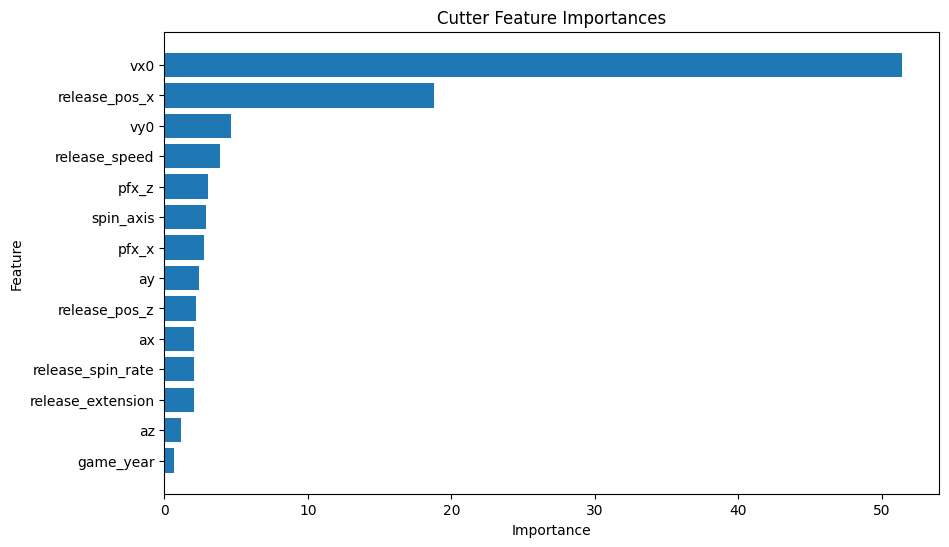

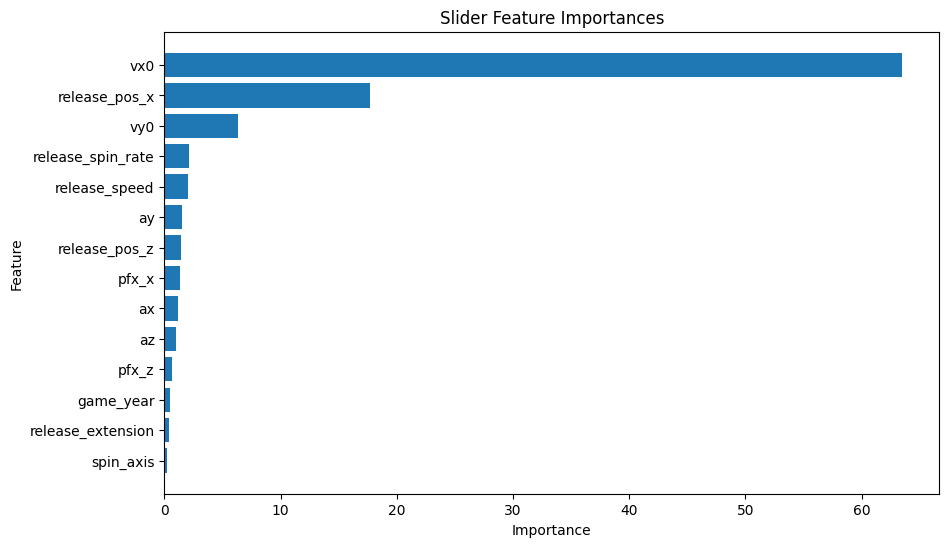

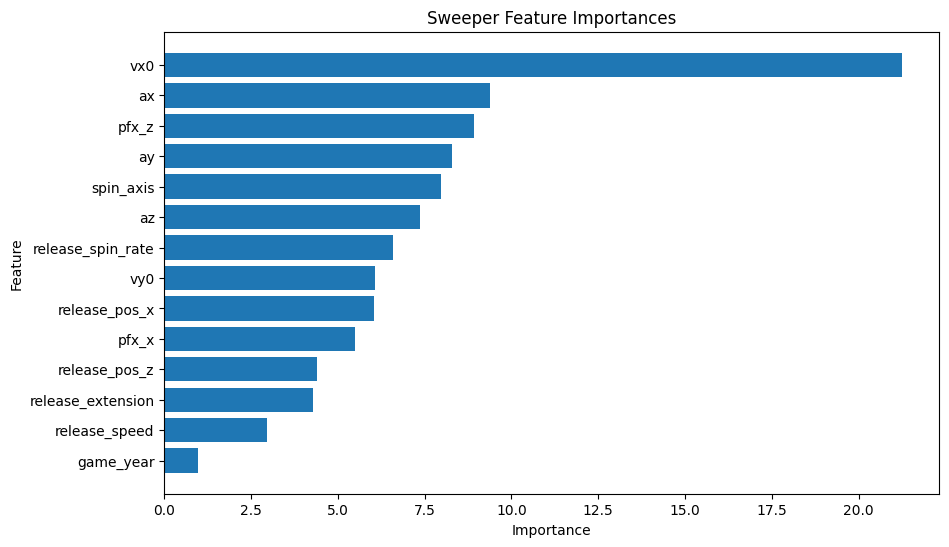

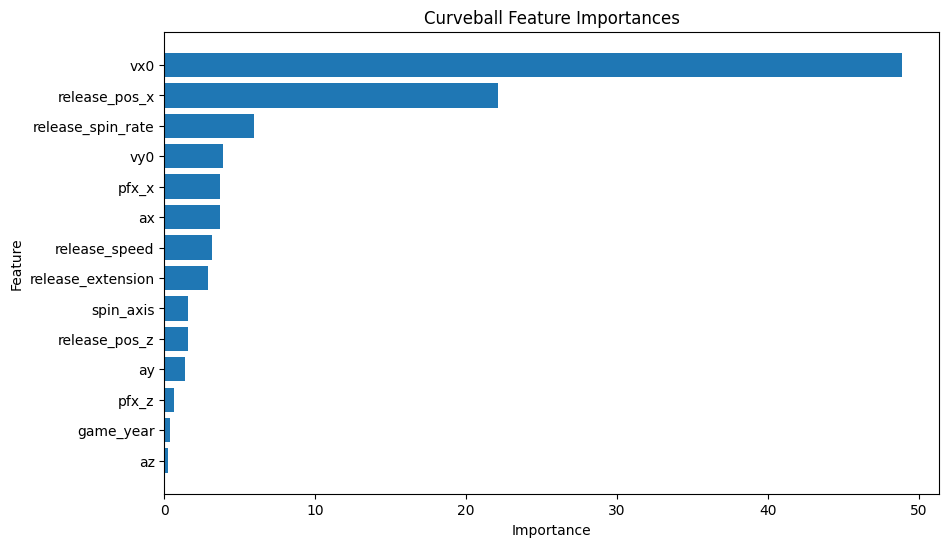

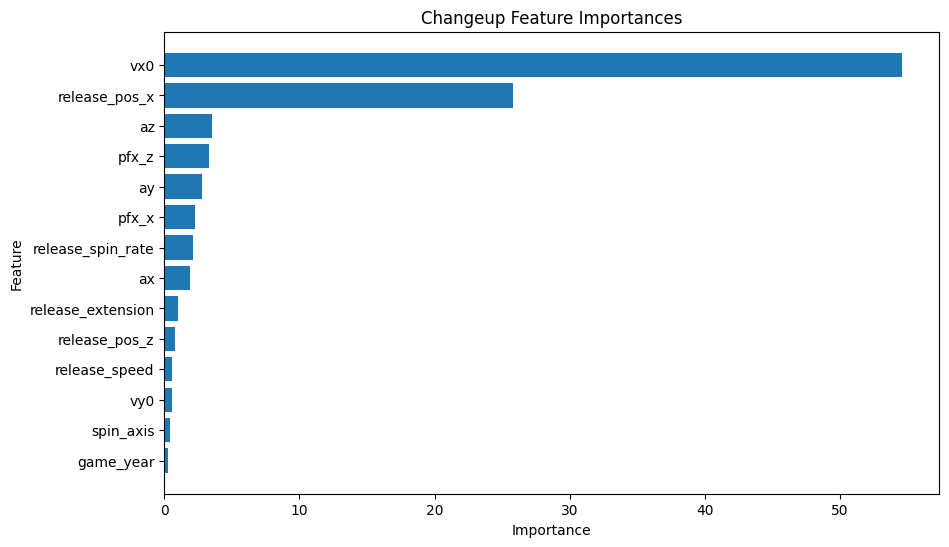

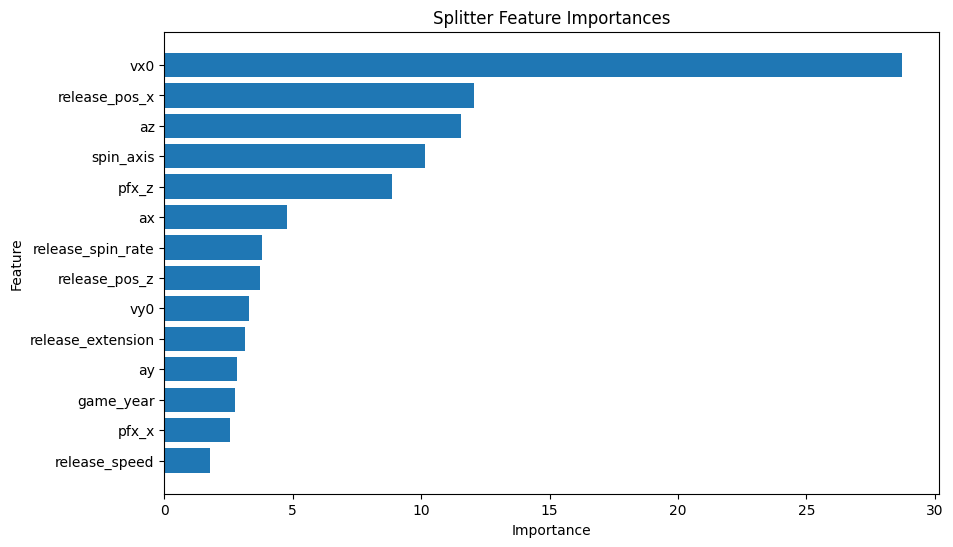

In [62]:
feature_cols = ['release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','ax','ay','az','game_year']


plot_feature_importances(fastball_model, feature_cols, 'Fastball Feature Importances')
plot_feature_importances(sinker_model, feature_cols, 'Sinker Feature Importances')
plot_feature_importances(cutter_model, feature_cols, 'Cutter Feature Importances')
plot_feature_importances(slider_model, feature_cols, 'Slider Feature Importances')
plot_feature_importances(sweeper_model, feature_cols, 'Sweeper Feature Importances')
plot_feature_importances(curveball_model, feature_cols, 'Curveball Feature Importances')
plot_feature_importances(changeup_model, feature_cols, 'Changeup Feature Importances')
plot_feature_importances(splitter_model, feature_cols, 'Splitter Feature Importances')


In [69]:
mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)

mean_scores_fastball.to_csv('fastball_mean_scores.csv', index=False)
mean_scores_sinker.to_csv('sinker_mean_scores.csv', index=False)
mean_scores_cutter.to_csv('cutter_mean_scores.csv', index=False)
mean_scores_slider.to_csv('slider_mean_scores.csv', index=False)
mean_scores_sweeper.to_csv('sweeper_mean_scores.csv', index=False)
mean_scores_curveball.to_csv('curveball_mean_scores.csv', index=False)
mean_scores_changeup.to_csv('changeup_mean_scores.csv', index=False)
mean_scores_splitter.to_csv('splitter_mean_scores.csv', index=False)